# Upscaling

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from diffusers import DiffusionPipeline
import torch

/opt/anaconda3/envs/wd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Charger le modèle pré entrainé avec une image

In [2]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

encoder = load_model('models/cnn_encoder.h5', custom_objects={'mse': mse})

In [3]:
def preprocess_image(image_path, target_size):
    # Charger l'image
    img = load_img(image_path, target_size=target_size)
    # Convertir en tableau numpy
    img_array = img_to_array(img) / 255.0 
    return np.expand_dims(img_array, axis=0) 

# Exemple
image_path = "data/dataset/valid/watermarked/021a08dc-df94-41c7-a6b9-17d42dceb543.png"
input_size = (196, 196) 
image = preprocess_image(image_path, input_size)


In [4]:
# Générer l'image nettoyée
cleaned_image = encoder.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


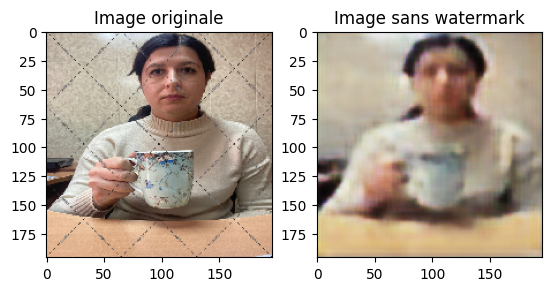

Résolution de l'image originale: (196, 196, 3)
Résolution de l'image nettoyée: (196, 196, 3)


In [5]:
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image[0])

plt.subplot(1, 2, 2)
plt.title("Image sans watermark")
plt.imshow(cleaned_image[0])
plt.show()

print(f"Résolution de l'image originale: {image[0].shape}")
print(f"Résolution de l'image nettoyée: {cleaned_image[0].shape}")

# Latent Diffusion Models (LDM) pour upscale notre image sans watermarks

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/ldm-super-resolution-4x-openimages"

pipeline = DiffusionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

low_res_img = Image.fromarray((cleaned_image[0] * 255).astype(np.uint8))

low_res_img = low_res_img.resize((128, 128))

upscaled_image = pipeline(low_res_img, num_inference_steps=100, eta=1).images[0]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]An error occurred while trying to fetch /Users/nico/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/nico/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /Users/nico/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/nico/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet.
Defaulting to unsafe serialization

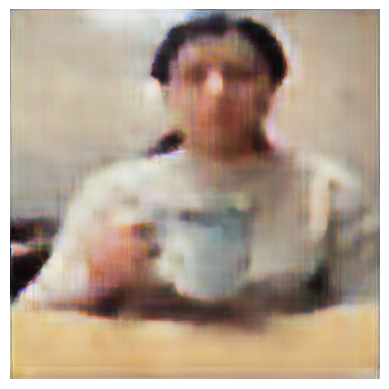

Résolution de l'image : (512, 512)


In [7]:
plt.imshow(upscaled_image)
plt.axis('off') 
plt.show()

print(f"Résolution de l'image : {upscaled_image.size}")